**Changes** - The data directories should be located directly in the data folder, not in subfolders by month. The load_data() function takes in the path to the data directory and the language to filter by (None returns all languages). It returns the data from the directories as a dataframe. I also added some additional data fields from the XML files to the dataframe.

I also unwound the short_descriptions to be strings (previously some had been lists, lists of ordered dicts, etc.) and fit a TF-IDF vectorizer to the result. I used the documents in French because there are a LOT more of them than in English, but French doesn't lend itself to being tokenized as well as English does (at least without some better regex's than I used), so the results aren't great.

In [1]:
import json
import os
import collections
import io
import numpy as np
import xmltodict
import wget
import pandas as pd
import json
import matplotlib.pyplot as plt
import urllib.request
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer

* [TED Schemas](https://publications.europa.eu/en/web/eu-vocabularies/tedschemashttps://publications.europa.eu/en/web/eu-vocabularies/tedschemas)
* [Forms in PDF ](http://simap.ted.europa.eu/standard-forms-for-public-procurement)
* [Daily Notices](https://data.europa.eu/euodp/data/dataset/ted-1/resource/0eec3f91-27f1-4ce0-91d2-102d82cb97ec)
* [Stop words in different languages](https://github.com/stopwords-iso)

In [91]:
# convert all currencies to EUR
def convert_currencies(values, currencies):
    url = "https://api.exchangeratesapi.io/latest"
    content = urllib.request.urlopen(url).read()
    exchange_rates = json.loads(content.decode())
    results = []
    
    for value, currency in zip(values, currencies):
        if currency == "EUR":
            results.append(value)
            
        else:
            try:
                exchange_rate = exchange_rates['rates'][currency]
                converted_value = float(value) / exchange_rate
                results.append(converted_value)
            # if we don't have a rate for the currency use NaN
            except:
                results.append(np.nan)
                
    return results

def unwind_descriptions(short_desc):
    # get the text from the OrderedDicts in the short descriptions
    for i, foo in enumerate(short_desc):
        if type(foo) != str:
            if type(foo) == list:
                for j, bar in enumerate(foo):
                    if type(bar) == collections.OrderedDict:
                        bar = bar['#text']
                        short_desc[i][j] = bar
            elif type(foo) == collections.OrderedDict:
                foo = foo['#text']
                short_desc[i] = foo

    # flatten the lists
    for i, foo in enumerate(short_desc):
        if type(foo) == list:
            foo = " ".join(foo)
            short_desc[i] = foo
            
    return short_desc

def flatten_xml_dicts(xml_dict, results_dict):
    for key in xml_dict.keys():
        if isinstance(xml_dict[key], collections.OrderedDict):
            for key2 in xml_dict[key]:
                if "text" in key2:
                    results_dict[key] = xml_dict[key][key2]
                elif "CODE" in key2:
                    results_dict[key + "_CODE"] = xml_dict[key][key2]
        elif isinstance(xml_dict[key], list):
            results_dict[key] = []
            results_dict[key + "_CODE"] = []
            for list_item in xml_dict[key]:
                if isinstance(list_item, collections.OrderedDict):
                    for key3 in list_item.keys():
                        if "text" in key3:
                            results_dict[key].append(list_item[key3])
                        elif "CODE" in key3:
                            results_dict[key + "_CODE"].append(list_item[key3])
        else:
            results_dict[key] = xml_dict[key]
            
    return results_dict

In [117]:
data_path = "./data"

def load_data(data_path, language="EN"):
    # get the list of the subdirectories
    dirs = os.listdir(data_path)
    parsed_xmls = []
    
    language_tenders = []
    all_tenders = []
    
    # loop through the subdirectories and get the list of files in each
    for dir_ in dirs[:1]:
        files = os.listdir(os.path.join(data_path, dir_))
        date = dir_.split("_")[0]
        
        # loop through the files
        for file in files:
            # read the contents of the file
            with io.open(os.path.join(data_path, dir_, file), 'r', encoding="utf-8") as f:
                xml = f.read()
                parsed_xml = xmltodict.parse(xml)
                parsed_xmls.append(parsed_xml)

                # get some header info
                forms_section = parsed_xml['TED_EXPORT']['FORM_SECTION']
                notice_data = parsed_xml['TED_EXPORT']['CODED_DATA_SECTION']['NOTICE_DATA']
                codif_data = parsed_xml['TED_EXPORT']['CODED_DATA_SECTION']['CODIF_DATA']
                
                header_info = {}
                header_info['DATE'] = date
                header_info['FILE'] = file
                
                header_info = flatten_xml_dicts(notice_data, header_info)
                header_info = flatten_xml_dicts(codif_data, header_info)
                
                if isinstance(notice_data['ORIGINAL_CPV'], list):
                    header_info['ORIGINAL_CPV_CODE'] = []
                    header_info['ORIGINAL_CPV_TEXT'] = []
                    for cpv_info in notice_data['ORIGINAL_CPV']:
                        header_info['ORIGINAL_CPV_CODE'].append(cpv_info['@CODE'])
                        header_info['ORIGINAL_CPV_TEXT'].append(cpv_info['#text'])
                else:
                    header_info['ORIGINAL_CPV_CODE'] = notice_data['ORIGINAL_CPV']['@CODE']
                    header_info['ORIGINAL_CPV_TEXT'] = notice_data['ORIGINAL_CPV']['#text']

                try:
                    header_info['VALUE'] = notice_data['VALUES']['VALUE']['#text']
                    header_info['VALUE_CURR'] = notice_data['VALUES']['VALUE']['@CURRENCY']
                    header_info['REF_NO'] = notice_data['REF_NOTICE']['NO_DOC_OJS']
                except:
                    header_info['VALUE'] = ""
                    header_info['VALUE_CURR'] = ""
                    header_info['REF_NO'] = ""
                    
                forms = forms_section.keys()
                
                for form in forms:
                    try:
                        form_contents = forms_section[form]
                            
                        if isinstance(form_contents, list):
                            for i, form_content in enumerate(form_contents):
                                all_tenders.append((header_info, form_content))
                                if language is not None and form_content['@LG'] == language:
                                    language_tenders.append((header_info, form_content))
                        elif isinstance(form_contents, collections.OrderedDict):
                            all_tenders.append((header_info, form_contents))
                            if language is not None and form_contents['@LG'] == language:
                                language_tenders.append((header_info, form_contents))
                    except Exception as e:
                        print("File 1", file, e)

    if language == None:
        language_tenders = all_tenders
    
    parsed_data = []
    for (header, tender) in language_tenders:
        flattened = {}
        
        # add some fields
        for key in header.keys():
            flattened[key] = header[key]
            
        flattened['LG'] = tender['@LG']
        
        try:
            for key, value in tender['CONTRACTING_BODY'].items():
                address_contracting_body = value
                try:
                    for key, value in address_contracting_body.items():
                        flattened[key.lower()] = value
                except:
                    pass
                
            flattened['title'] = tender['OBJECT_CONTRACT']['TITLE']['P']
            flattened['short_description'] = tender['OBJECT_CONTRACT']['SHORT_DESCR']['P']
            
            # unwind some fields
            flattened['country'] = flattened['country']['@VALUE']
            flattened['n2016:nuts'] = flattened['n2016:nuts']['@CODE']
            
            parsed_data.append(flattened)
        except:
            print(flattened['FILE'], "no contracting body")

    df = pd.DataFrame(parsed_data)
        
    # convert Currencies to Euros
    df['VALUE_EUR'] = convert_currencies(df['VALUE'].values, df['VALUE_CURR'].values)
    
    # unwind the descriptions to be strings
    df['short_desc_str'] = unwind_descriptions(df['short_description'].fillna("none").values)
    
    return df

In [118]:
df = load_data(data_path, language="EN")

000004_2019.xml no contracting body
000005_2019.xml no contracting body
000006_2019.xml no contracting body
000007_2019.xml no contracting body
000008_2019.xml no contracting body
000009_2019.xml no contracting body
000010_2019.xml no contracting body
000011_2019.xml no contracting body
000012_2019.xml no contracting body
000013_2019.xml no contracting body
000014_2019.xml no contracting body
000015_2019.xml no contracting body
000016_2019.xml no contracting body
000017_2019.xml no contracting body
000018_2019.xml no contracting body
000019_2019.xml no contracting body
000020_2019.xml no contracting body
000591_2019.xml no contracting body
001373_2019.xml no contracting body
001377_2019.xml no contracting body
001378_2019.xml no contracting body
001424_2019.xml no contracting body
001425_2019.xml no contracting body
001426_2019.xml no contracting body
001427_2019.xml no contracting body
001428_2019.xml no contracting body
001445_2019.xml no contracting body
001472_2019.xml no contracti

In [120]:
df.head()

,@value,AA_AUTHORITY_TYPE,AA_AUTHORITY_TYPE_CODE,AC_AWARD_CRIT,AC_AWARD_CRIT_CODE,DATE,DS_DATE_DISPATCH,DT_DATE_FOR_SUBMISSION,FILE,HEADING,...,p,phone,postal_code,short_description,title,town,url_buyer,url_general,VALUE_EUR,short_desc_str
0,ECONOMIC_AND_FINANCIAL_AFFAIRS,European Institution/Agency or International O...,5,The most economic tender,2,20190102,20181220,20190207 11:00,000001_2019.xml,AGC02,...,NaN,+352 2609620,L-1347,[Where expert knowledge on complex facilities ...,Provision of consultancy services for Faciliti...,Luxembourg,NaN,https://www.esm.europa.eu/procurement,NaN,Where expert knowledge on complex facilities m...
1,GENERAL_PUBLIC_SERVICES,European Institution/Agency or International O...,5,The most economic tender,2,20190102,20181221,NaN,000002_2019.xml,AGC03,...,NaN,NaN,1210,[EASME is launching an Invitation to Tender wi...,Bathymetry — High Resolution Seabed Mapping,Brussels,https://ec.europa.eu/easme/en,http://ec.europa.eu/EASME,7439450.70,EASME is launching an Invitation to Tender wit...
2,GENERAL_PUBLIC_SERVICES,European Institution/Agency or International O...,5,The most economic tender,2,20190102,20181221,NaN,000003_2019.xml,AGC03,...,NaN,NaN,1210,[EASME is launching this call for tenders divi...,"""Assistance Mechanism for the Western Mediterr...",Brussels,NaN,http://ec.europa.eu/EASME,1590482.50,EASME is launching this call for tenders divid...
3,GENERAL_PUBLIC_SERVICES,European Institution/Agency or International O...,5,The most economic tender,2,20190102,20181221,20190206,000021_2019.xml,CLC02,...,NaN,+32 2-281-8062,1048,See II.2.4).,UCA 18/068 — Management of the crèche at the G...,Bruxelles,http://www.consilium.europa.eu/contacts/procur...,https://tendering.consilium.europa.eu,NaN,See II.2.4).
4,EU_INSTITUTION,European Institution/Agency or International O...,5,The most economic tender,2,20190102,20181221,NaN,000022_2019.xml,ECC03,...,NaN,NaN,E-41092,[EUROMOD is a tax-benefit microsimulation mode...,Technical Support for the Development and Upda...,Sevilla,https://etendering.ted.europa.eu/cft/cft-displ...,https://ec.europa.eu/jrc/,490000.00,EUROMOD is a tax-benefit microsimulation model...


In [121]:
df.columns

Index(['@value', 'AA_AUTHORITY_TYPE', 'AA_AUTHORITY_TYPE_CODE',
       'AC_AWARD_CRIT', 'AC_AWARD_CRIT_CODE', 'DATE', 'DS_DATE_DISPATCH',
       'DT_DATE_FOR_SUBMISSION', 'FILE', 'HEADING', 'IA_URL_ETENDERING',
       'IA_URL_GENERAL', 'INITIATOR', 'LG', 'LG_ORIG', 'MA_MAIN_ACTIVITIES',
       'MA_MAIN_ACTIVITIES_CODE', 'NC_CONTRACT_NATURE',
       'NC_CONTRACT_NATURE_CODE', 'NO_DOC_OJS', 'ORIGINAL_CPV',
       'ORIGINAL_CPV_CODE', 'ORIGINAL_CPV_TEXT', 'PR_PROC', 'PR_PROC_CODE',
       'REF_NO', 'RP_REGULATION', 'RP_REGULATION_CODE', 'TD_DOCUMENT_TYPE',
       'TD_DOCUMENT_TYPE_CODE', 'TY_TYPE_BID', 'TY_TYPE_BID_CODE', 'VALUE',
       'VALUE_CURR', 'address', 'contact_point', 'country', 'e_mail', 'fax',
       'n2016:CA_CE_NUTS', 'n2016:CA_CE_NUTS_CODE', 'n2016:PERFORMANCE_NUTS',
       'n2016:PERFORMANCE_NUTS_CODE', 'n2016:TENDERER_NUTS',
       'n2016:TENDERER_NUTS_CODE', 'n2016:nuts', 'nationalid', 'officialname',
       'p', 'phone', 'postal_code', 'short_description', 'title', 'to

In [93]:
df.loc[df['ORIGINAL_CPV_CODE'] == "45215100"]

,@value,DATE,FILE,LG,NO_DOC_OJS,ORIGINAL_CPV_CODE,ORIGINAL_CPV_TEXT,REF_NO,VALUE,VALUE_CURR,...,p,phone,postal_code,short_description,title,town,url_buyer,url_general,VALUE_EUR,short_desc_str
0,GENERAL_PUBLIC_SERVICES,20190102,000025_2019.xml,ES,2019/S 001-000025,45215100,Construction work for buildings relating to he...,2018/S 188-423874,46944466.16,EUR,...,NaN,+34 981544516,15781,Ampliación del Hospital Arquitecto Marcide en ...,Ejecución de las obras de la fase 1 del Comple...,Santiago de Compostela,NaN,http://www.xunta.gal,46944466.16,Ampliación del Hospital Arquitecto Marcide en ...
3052,HEALTH,20190201,049330_2019.xml,PT,2019/S 023-049330,45215100,Construction work for buildings relating to he...,2018/S 183-415008,1320000.00,EUR,...,NaN,+351 295204273,9701-878,Empreitada de reabilitação e beneficiação do e...,Concurso público para empreitada de reabilitaç...,Angra do Heroísmo,NaN,http://www.saudacor.pt,1320000.00,Empreitada de reabilitação e beneficiação do e...
3069,SOCIAL_PROTECTION,20190201,049366_2019.xml,DE,2019/S 023-049366,45215100,Construction work for buildings relating to he...,2018/S 118-267237,68369.00,EUR,...,NaN,+49 6232 / 17-0,67346,[ca. 230 m Zementestrich auf Treppenpodesten u...,Naturwerksteinarbeiten Erweiterung Drei-Burgen...,Speyer,NaN,http://www.deutsche-rentenversicherung.de/Rhei...,68369.00,ca. 230 m Zementestrich auf Treppenpodesten un...
4604,HEALTH,20190206,057167_2019.xml,DE,2019/S 026-057167,45215100,Construction work for buildings relating to he...,2018/S 129-295241,44388.62,EUR,...,NaN,+49 3514586194,01307,[Neubau eines 4-geschossigen Forschungsgebäude...,"Haus 136 – Neubau Forschungsgebäude NCT, Los 3...",Dresden,NaN,www.uniklinikum-dresden.de,44388.62,Neubau eines 4-geschossigen Forschungsgebäudes...
4615,HEALTH,20190206,057193_2019.xml,DE,2019/S 026-057193,45215100,Construction work for buildings relating to he...,2017/S 158-327819,1210602.04,EUR,...,NaN,+49 3514586194,01307,"[Kurze Beschreibung:, Neubau eines 4-geschossi...","Haus 137 – Molekulares Forschungslabor (MFL), ...",Dresden,NaN,www.uniklinikum-dresden.de,1210602.04,Kurze Beschreibung: Neubau eines 4-geschossige...


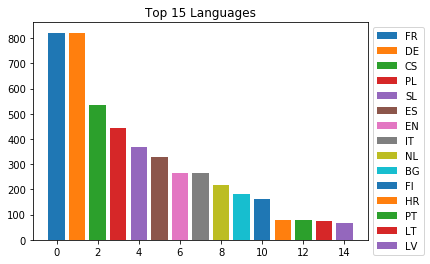

In [7]:
languages = pd.value_counts(df.LG)
for i, lang in enumerate(languages.index[:15]):
    plt.bar(i, languages[lang], label=lang)
    
plt.legend(bbox_to_anchor=(1,1))
plt.title("Top 15 Languages")
plt.show()

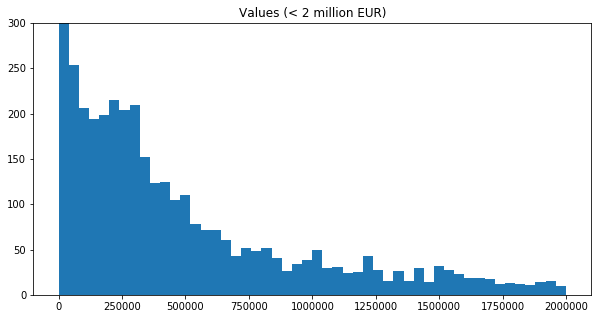

In [8]:
values = df['VALUE_EUR'].astype("float")
plt.figure(figsize=(10,5))
plt.hist(values[values < 2000000] , bins=50)
plt.title("Values (< 2 million EUR)")
plt.ylim(0, 300)
plt.show()

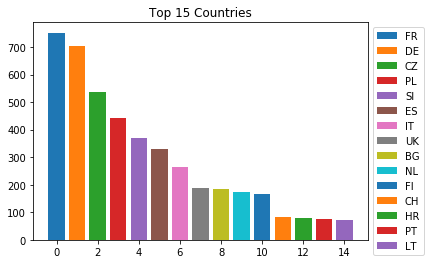

In [9]:
countries = pd.value_counts(df['country'])
for i, country in enumerate(countries.index[:15]):
    plt.bar(i, countries[country], label=country)
    
plt.legend(bbox_to_anchor=(1,1))
plt.title("Top 15 Countries")
plt.show()

### Vectorize Text

In [71]:
# get text takes in a dataframe and a language, it will extract the short_description fields for
# the specified language from the dataframe and return those along with the stop words for
# that language.
def get_text(df, lang):
    lang = lang.upper()
    def get_stop_words(lang="EN"):
        lang = lang.lower()
        file_name = "stopwords-" + lang + ".txt"
        if not os.path.exists(file_name):
            print("File", file_name,  "doesn't exist, trying to download")

            # try to download the file
            try:
                wget.download("https://raw.githubusercontent.com/stopwords-iso/stopwords-"+lang+"/master/"+file_name)
                stop_words_df = pd.read_csv(file_name, header=None)
            except:
                print("Error downloading!")
                return []
        else:
            stop_words_df = pd.read_csv(file_name, header=None)

        stop_words = list(stop_words_df[0].values)
        return stop_words
    
    description = df.loc[df["LG"] == lang, 'short_desc_str']
    stop_words = get_stop_words(lang)
    
    return description, stop_words

In [77]:
short_desc, stop_words = get_text(df, "FR")

In [78]:
# Fit our TF-IDF vectorizer
tfv = TfidfVectorizer(min_df=20,  max_features=None,
        strip_accents='unicode', analyzer='word', token_pattern=r'(?u)\b\w+\b',
        ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words=stop_words,
        )

tfv.fit(short_desc)
tfidf_feats = tfv.transform(short_desc)

In [79]:
tfv.get_feature_names()

['000',
 '000 eur',
 '000 eur ht',
 '1',
 '1 1',
 '1 1 2019',
 '1 2019',
 '1 an',
 '12',
 '2',
 '2015',
 '2015 899',
 '2016',
 '2016 360',
 '2016 360 25',
 '2016 relatif',
 '2016 relatif marches',
 '2019',
 '25',
 '25 3',
 '25 3 2016',
 '3',
 '3 2016',
 '3 2016 relatif',
 '31',
 '31 12',
 '360',
 '360 25',
 '360 25 3',
 '4',
 '5',
 '6',
 '66',
 '67',
 '67 68',
 '68',
 '68 decret',
 '7',
 '78',
 '78 80',
 '78 80 decret',
 '80',
 '80 decret',
 '80 decret no',
 '899',
 'accord',
 'accord cadre',
 'accord cadre bons',
 'accord cadre conclu',
 'accords',
 'accords cadres',
 'acquisition',
 'agit',
 'agit accord',
 'agit accord cadre',
 'an',
 'annuel',
 'ans',
 'appel',
 'appel offres',
 'application',
 'application articles',
 'article',
 'articles',
 'articles 25',
 'articles 78',
 'articles 78 80',
 'assistance',
 'assurance',
 'attributaire',
 'attribution',
 'attribution marche',
 'batiments',
 'besoins',
 'bons',
 'bons commande',
 'bons commande minimum',
 'cadre',
 'cadre bons',
 'c

In [80]:
tfidf_feats.shape

(822, 217)